# Мини туториал по Билдеру 25-01-2024

In [1]:
from auto_robot_design.description.actuators import TMotor_AK80_9

from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator

Кинематика рычажных механизмов полностью определяется расположением кинематических пар и связей между ними с помощью звеньев. Исходя из этого механизмы можно описать координатами сочленений и связями между ними. Зададим пространство сочленений, как вершины графа $j \in \mathcal{J}$. Для описания параметров сочленений, составлен вектор признаков вершин: $x_j = \begin{bmatrix}x & y & \mathbb{I}_g & \mathbb{I}_{ee} & \mathbb{I}_{weld} & \mathbb{I}_{act}\end{bmatrix}$, где $(x, y)$ - пара декартовых координат начального положения сочленения в глобальной системе $\Psi_\text{w}$, $\mathbb{I}$ - функция индикатор является ли соединение фиксированным $\mathbb{I}_{ee}$,  $\mathbb{I}_{act}$ активируемой и присоединена ли вершина к земле $\mathbb{I}_g$, или к концевому эффектору (end effector) $\mathbb{I}_{ee}$. Звенья задаются ребрами между вершинами $\mathcal{L} \subseteq \{(j_k, j_m)| \; \forall j_k,\, j_m \in \mathcal{J}, j_k \neq j_m \}$ и имеют два атрибута:  функция индикатор переменной длины $\mathbb{I}_{var}$ и активности $\mathbb{I}_{act}$ звена.  

Пайплайн Билдера состоит из несколько этапов, которые заключены в функциях `JointPoint2KinematicGraph`, `KinematicGraph.define_main_branch()`, `KinematicGraph.define_span_tree()`, `KinematicGraph.define_link_frames()`, `Builder.create_kinematic_graph(KinematicGraph)`. Первая функция преобразует *JP* граф в кинематический граф `KinematicGraph`. Три следующие функции являются методами кинематического графа, они требуются определения информации о структуре механизма для создания *URDF* или *MJCF*. И последняя функция собирает *URDF* по входному графу.

Работу каждой функции покажем на примере сгенерированного механизма с двумя звеньями в главной ветке и присоединенной группой 4n6p

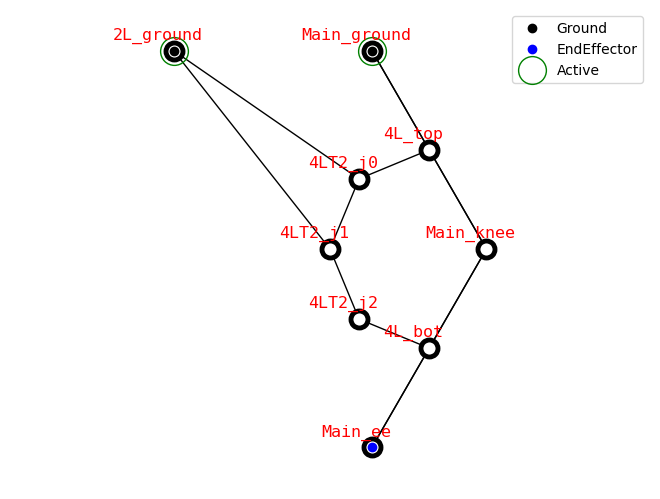

In [2]:
from auto_robot_design.description.utils import draw_joint_point


gen = TwoLinkGenerator()
graph, constrain_dict = gen.get_standard_set()[5]
draw_joint_point(graph)

Для создания *URDF*, *JP* граф необходимо определить фермы (треугольники) и разделить на тела. Для этой задачи я вывел несколько простых правил и написал алгоритм для обхода графа в глубину, Алгоритм работает для плоских механизмов с вращательными парами. 

Условия для определения тел базируется на подсчете соседей у текущей вершины $j$ и у соседних и добавлен, ли джоинт в линк. Алгоритм написан так, чтобы рассматриваемая вершина входило в звено $L_j$. Для текущей вершины $j$ находится соседи $N_j$, которые не входит в звено $L_j$. Обозначим их $\theta_i \in \Theta_j \subseteq N_j / L_j$. Дальше находится соседи соседей вершин ${W}_j = \bigcup_{i}Adj [\theta_i]$. По этим множестам определяется структуру, которую соединяет вершины. Рассмотрим последовательно с простых к сложным случаем.

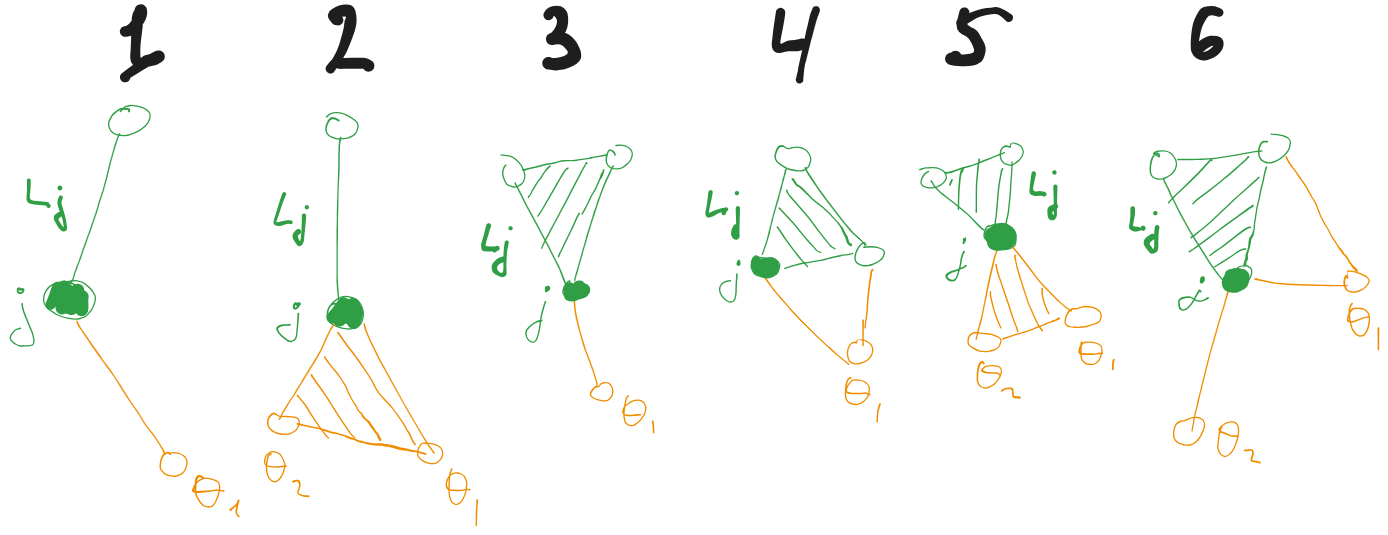

- $|L_j| \leq 2$ - Из чего следует, что в звено входит два джоинта или меньше (к примеру земля). Это 1 и 2 рисунок. В таком случае сразу создается новое звено, в которое добавляются соседи $\Theta_j$ и текущая вершина $j$. 

- $|L_j| > 2$ - представлены на рисунке 3-6. Тут принципиально разные структуры и необходимо дополнительая проверка. 
    - $|\Theta_j| = 1$ - Сосед у звена один, поэтому это случа 3, 4. Их можно разделить количеством соседей у $\theta_i$, которые входят в звено $|W_j \cap L_j|$. Третий рисунок соотвествует одному соседу, тогда создается новое звено. Если имеет два соседа, то вершина присоединяется к звену $L_j$.
    - $|\Theta_j| = 2$ - Две соседние вершины у звена (рисунки 5-6). Так же различие определяется количеством соседей с вершинами звена $L_j$ у соседей $\theta_j$ текущей вершины $j$. Алгоритм схож с предыдущем случаем.

Теперь опишем алгоритм обхода графа. 

Алгоритм начинается с создания звена земли и энд-еффектора, в них добавляются все вершины, в которых включены соответствующие флаги. В стэк добавляется все вершины земли и запускается основной цикл. В цикле из стэка достается вершина, определяется предыдущее звено, собираются множества для структуры. Проверяются условия, описанные ранее. После этого в стэк добавляются соседи, если к ним не присоединено второе звено. Цикл завершится, когда стэк станет пустым. 

В каждом джоинте есть поле, которое содержит звенья присоединения. По этому полю строяться ребра в кинематическом графе. 

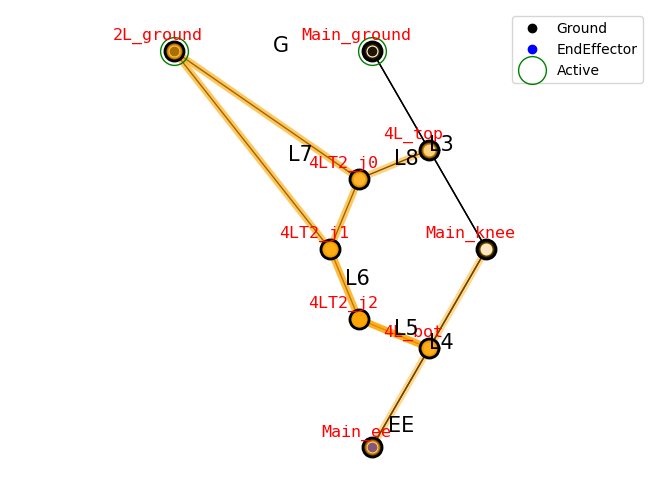

In [3]:
from auto_robot_design.description.mechanism import JointPoint2KinematicGraph
from auto_robot_design.description.utils import draw_links

kinematic_graph = JointPoint2KinematicGraph(graph)
draw_links(kinematic_graph, graph)

В итоге на выходе функция мы получаем кинематический граф

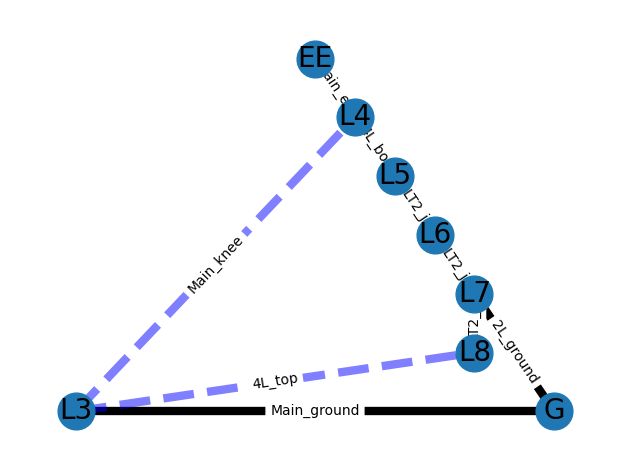

In [4]:
from auto_robot_design.description.utils import draw_kinematic_graph
draw_kinematic_graph(kinematic_graph)

Следующий этап -- определить главную ветку и найти span tree. Главную ветку будем определять по геометрической длине звеньев и актуаторам. Это означает, что мы отдаем предпочтение пути от G к EE, которая включает самые длинные звенья и максимальное количество актуаторов. Этот путь определяет функция `networkx.shortest_path()`, которая ищет кратчайший путь взвешенного графа. Веса рассчитываются с помощью функции `utils.weight_by_dist_active()`. 

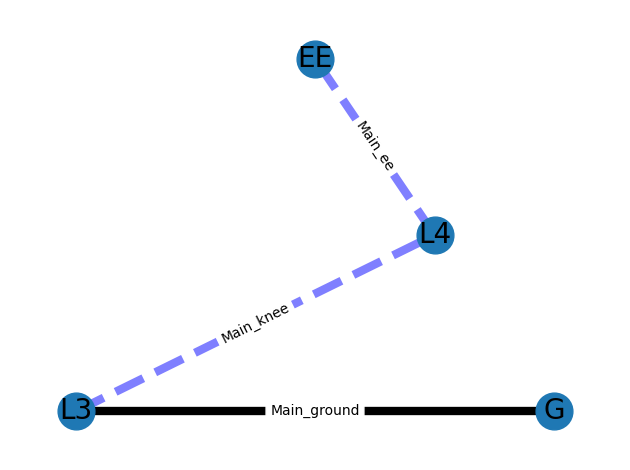

In [5]:
main_branch = kinematic_graph.define_main_branch()
draw_kinematic_graph(main_branch)

По полученному графу необходимо получить остовное дерево (span tree) для дальнейших алгоритмов. _Википедия:_ Неформально говоря, остовное дерево получается из исходного графа удалением максимального числа рёбер, входящих в циклы, но без нарушения связности графа. В общем, граф содержит несколько span tree. 

Необходимо задать правила для получения удобного span tree для последующих алгоритмов.

 - Нельзя разрывать главную ветку
 - Удаленные ребра в среде моделирования будут задаваться, как ограничения в системе (`equation`, `constraint`). 
- Нельзя разрывать ребра, в которых активные кинематические пары. В системе нельзя поставить актуатор на ограничения. 
- Желательно разрывать кинематические циклы при присоединении к основной кин. цепочке. 
- Один из листьев дерева должен быть *EE*.

По данным правилам рассчитываются веса ребер, расчет можно посмотреть в функции `utils.calc_weight_for_span`. А дальше алгоритм из библиотеки `networkx` ищет span tree с максимальной суммой весов. 

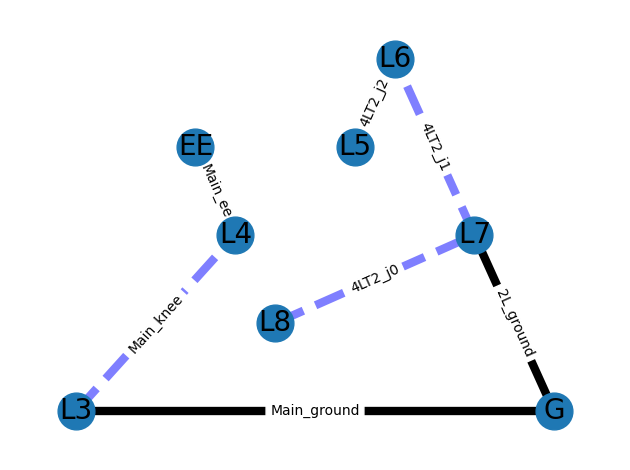

In [6]:

kin_tree = kinematic_graph.define_span_tree()
draw_kinematic_graph(kin_tree)

Осталось определить параметры механизма и фреймы для тел. С параметрами все ясно, а вот как определить фреймы? Для звеньев всего лишь с двумя джоинтами очевидно выставляет фрейм так, чтобы одна из осей была соосна со звеном. Чтобы упростить задачу построения _URDF_, фреймы размещаем во входном джоинте. 

Теперь рассмотрим звено более чем с двумя джоинтами. Для них было решено не создавать велосипед, а использовать веса похожие в предыдущих этапах. Однако, теперь есть основные пути -- главная ветка и span_tree. Если выходная вершина входит в главную ветку, то ось фрейм располагается между нее и входным джоинтом. Иначе, проверяется какие джоинты входят в span_tree. И тогда ось фрейма соосна самым длинным вектором проложенным от входного джоинта и джоинта в span_tree. И последний приоритет отдается джоинтам-ограничеиям (не входят span_tree). 

Инерциальные фреймы размещяются как средняя точка между джоинтами и он сонаправлен с фреймом тела

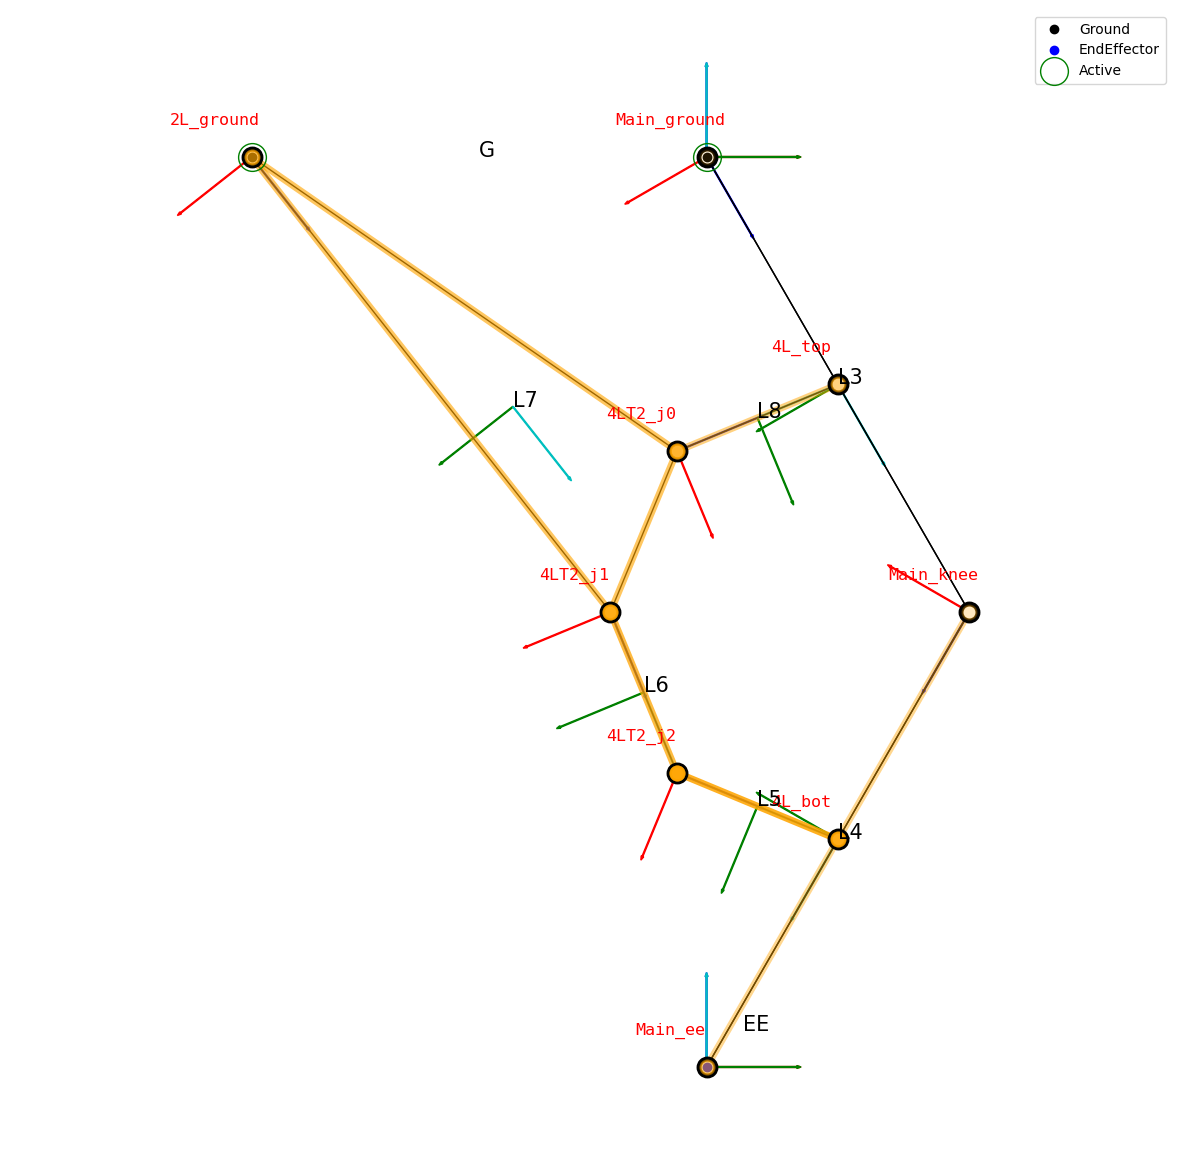

In [7]:
from auto_robot_design.description.utils import draw_link_frames


thickness = 0.04
density = 2700 / 2.8

for n in kinematic_graph.nodes():
    n.thickness = thickness
    n.density = density

for j in kinematic_graph.joint_graph.nodes():
    j.pos_limits = (-np.pi, np.pi)
    if j.jp.active:
        j.actuator = TMotor_AK80_9()
    j.damphing_friction = (0.05, 0)
    
kinematic_graph.define_link_frames()
draw_link_frames(kinematic_graph)
draw_links(kinematic_graph, graph)

`Builder` лишь интерфейс, который для каждого звена и джоинта в графе создает объект. Объект, который будет создавать описан в `DetalizedURDFCreater`. В нем есть две функции `create_joint` для создания объекта джоинт и `create_link` для линков. По информации вершин, метод понимает как собрать объект.

Теперь появился новый билдер `ParametrizedBuilder`. Теперь в нем можно задать кинематические и инерциальные параметры и он будет собирать объекты по ним. Теперь нет необходимости задавать параметры графа по отдельно, достаточно определить их при инициализации `ParametrizedBuilder`.

```python
thickness = 0.04
density = 2700 / 2.8


builder = ParametrizedBuilder(DetalizedURDFCreaterFixedEE,
                              density=density,
                              thickness={"default": thickness, "EE":0.08},
                              actuator=TMotor_AK60_6(),
                              size_ground=np.array([thickness*5, thickness*10, thickness*2]),
)

robo_urdf, __, __ = jps_graph2urdf_by_bulder(graph, builder)
```

In [8]:
from auto_robot_design.description.builder import Builder, URDFLinkCreator

builder = Builder(URDFLinkCreator)

robot, ative_joints, constraints = builder.create_kinematic_graph(kinematic_graph)

In [9]:
robot.urdf

<bound method Robot.urdf of <?xml version="1.0"?>
<robot  name="Robot" >
 <link  name="L3" >
  <visual >
   <origin  xyz="-2.0816681711721685e-17 0.0 0.4330127018922193"  rpy="0.0 0.0 0.0" />
   <geometry >
    <box  size="0.03999999910593033 0.03999999910593033 0.24867513548888254" />
   </geometry>
   <material  name="L3_Material" >
    <color  rgba="0.7779971307236956 0.7067166075617947 0.4781354117055029 1.0" />
   </material>
  </visual>
  <collision  name="L3_0_Collision" >
   <origin  xyz="-2.0816681711721685e-17 0.0 0.4330127018922193"  rpy="0.0 0.0 0.0" />
   <geometry >
    <box  size="0.03999999910593033 0.03999999910593033 0.24867513548888254" />
   </geometry>
  </collision>
  <visual >
   <origin  xyz="-6.938893903907228e-18 0.0 0.14433756729740643"  rpy="0.0 0.0 0.0" />
   <geometry >
    <box  size="0.03999999910593033 0.03999999910593033 0.24867513548888254" />
   </geometry>
   <material  name="L3_Material" >
    <color  rgba="0.7779971307236956 0.7067166075617947 0.4